In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
%matplotlib inline

In [2]:
train = MNIST('../DATASETS/MNIST_pytorch/', train=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
    ]),
#              download=True,
             )

test = MNIST('../DATASETS/MNIST_pytorch/', train=False, transform=transforms.ToTensor(),
#             download=True,
            )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [3]:
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Transformed Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1306)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [4]:
test_data = test.data
test_data = train.transform(test_data.numpy())

print('[Test]')
print(' - Numpy Shape:', test.data.numpy().shape)
print(' - Tensor Shape:', test.data.size())
print(' - Transformed Shape:', test_data.size())
print(' - min:', torch.min(test_data))
print(' - max:', torch.max(test_data))
print(' - mean:', torch.mean(test_data))
print(' - std:', torch.std(test_data))
print(' - var:', torch.var(test_data))

[Test]
 - Numpy Shape: (10000, 28, 28)
 - Tensor Shape: torch.Size([10000, 28, 28])
 - Transformed Shape: torch.Size([28, 10000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1325)
 - std: tensor(0.3105)
 - var: tensor(0.0964)


In [91]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(784, 10)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(10, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = F.relu(h)        
        h = self.fc2(h)
        out = self.softmax(h)
        return out

model = Model()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [92]:
def normalize_weight_vector(matrix): ## takes input weight of pytorch tensor
    matrix = matrix.data
    with torch.no_grad():
        for i in range(matrix.shape[0]):
            matrix[i] = matrix[i]/torch.norm(matrix[i], p=2)
    return matrix

In [93]:
model.fc1.weight.shape, model.fc1.weight

(torch.Size([10, 784]), Parameter containing:
 tensor([[ 0.0001,  0.0082,  0.0240,  ..., -0.0243, -0.0140, -0.0137],
         [ 0.0284, -0.0308,  0.0344,  ..., -0.0333, -0.0110, -0.0222],
         [-0.0009, -0.0013,  0.0144,  ..., -0.0333, -0.0009, -0.0157],
         ...,
         [-0.0064, -0.0315,  0.0233,  ..., -0.0204,  0.0220, -0.0190],
         [ 0.0288,  0.0284,  0.0149,  ...,  0.0123, -0.0006, -0.0124],
         [ 0.0274,  0.0206, -0.0197,  ...,  0.0005, -0.0097,  0.0041]],
        requires_grad=True))

In [94]:
normalize_weight_vector(model.fc1.weight)

tensor([[ 0.0002,  0.0146,  0.0426,  ..., -0.0430, -0.0249, -0.0243],
        [ 0.0494, -0.0535,  0.0598,  ..., -0.0579, -0.0191, -0.0385],
        [-0.0016, -0.0024,  0.0257,  ..., -0.0594, -0.0015, -0.0280],
        ...,
        [-0.0110, -0.0539,  0.0398,  ..., -0.0349,  0.0376, -0.0324],
        [ 0.0490,  0.0485,  0.0253,  ...,  0.0210, -0.0010, -0.0211],
        [ 0.0472,  0.0355, -0.0340,  ...,  0.0009, -0.0167,  0.0070]])

In [95]:
# model.train()
evaluate_x = Variable(test_loader.dataset.data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.targets)

losses = []
for epoch in range(5):
    data_count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = criterion(y_pred, target)
        losses.append(loss.data)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        normalize_weight_vector(model.fc1.weight)
#         normalize_weight_vector(model.fc2.weight)
        
        # Display
        data_count += len(data)
        if batch_idx%100 == 0 or batch_idx==len(train_loader)-1:
            output = model(evaluate_x)
            pred = output.max(1)[1]
            d = pred.eq(evaluate_y)
            accuracy = float(d.sum())/float(d.size()[0])
            
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                epoch, 
                data_count, 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data,
                accuracy,),
                end='')
            
    print()

 Train Epoch: 0 [672/60000 (100%)]	Loss: 0.437160	Accuracy: 0.8822
 Train Epoch: 1 [672/60000 (100%)]	Loss: 0.649102	Accuracy: 0.8763
 Train Epoch: 2 [672/60000 (100%)]	Loss: 0.444874	Accuracy: 0.8679
 Train Epoch: 3 [672/60000 (100%)]	Loss: 0.315479	Accuracy: 0.8577
 Train Epoch: 4 [672/60000 (100%)]	Loss: 0.281783	Accuracy: 0.8387


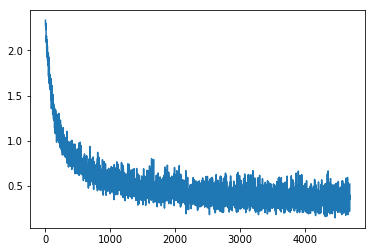

In [75]:
plt.plot(losses)

In [76]:
evaluate_x = test.data.type_as(torch.FloatTensor())
evaluate_y = test_loader.dataset.targets


output = model(evaluate_x)
pred = output.max(dim=1)[1]
d = pred.eq(evaluate_y)
accuracy = float(d.sum())/float(d.size()[0])

print('Accuracy:', accuracy)

Accuracy: 0.8718


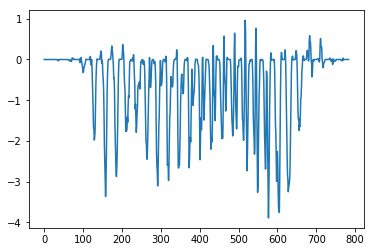

In [77]:
optimizer.zero_grad()
output = model(evaluate_x)
loss = criterion(output, evaluate_y)
loss.backward()
# model.fc1.weight.grad.max()
plt.plot(model.fc1.weight.grad.data[0].numpy())

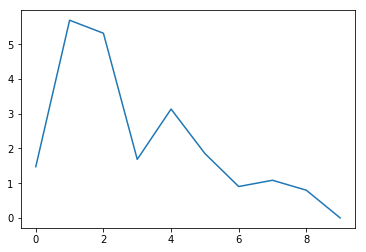

In [78]:
optimizer.zero_grad()
output = model(evaluate_x)
loss = criterion(output, evaluate_y)
loss.backward()
# model.fc2.weight.grad.max()
plt.plot(model.fc2.weight.grad.data[0].numpy())

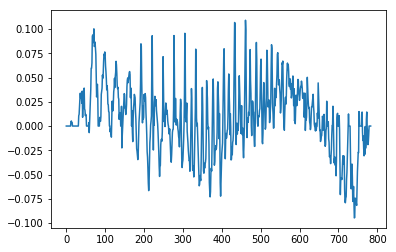

In [79]:
## the weights
plt.plot(model.fc1.weight.data[0].numpy())

In [80]:
torch.norm(model.fc1.weight.data[0], p=2)

tensor(1.0000)